In [1]:
import gzip
from collections import defaultdict
import math
import scipy
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
import numpy as np 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

In [4]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [5]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [6]:
answers = {}

In [7]:
# Some data structures that will be useful

In [8]:
allRatings = []
for l in readCSV("assignment1/train_Interactions.csv.gz"):
    allRatings.append(l)

In [9]:
len(allRatings)

200000

In [10]:
ratingsTrain = allRatings[:190000]
ratingsValid = allRatings[190000:]
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for u,b,r in ratingsTrain:
    ratingsPerUser[u].append((b,r))
    ratingsPerItem[b].append((u,r))
num_users = len(ratingsPerUser)
num_items = len(ratingsPerItem)

# this needs to be done for entire dataset 
ratingDict = defaultdict(float)
for u,b,r in allRatings:
    ratingDict[(u,b)] = float(r)

In [11]:
##################################################
# Rating prediction (CSE258 only)                #
##################################################

In [12]:
# get labels 
ratingsLabels = [d[-1] for d in ratingsTrain]
globalAverage = sum([d[-1] for d in ratingsTrain]) / len(ratingsTrain)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

In [13]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [14]:
# define mean and bias terms as global variables 
alpha = globalAverage
betaUser = defaultdict(float)
betaItem = defaultdict(float)
reg_lambda = 1 

# update mean and bias iteratively as described in lecture notes update equations.  
def update_params(param):
    global alpha
    global betaUser
    global betaItem
    
    alpha = param[0]
    betaUser = dict(zip( users, param[ 1 : (num_users+1) ]) )
    betaItem = dict(zip( items, param[ (1+num_users) : ]) )

In [15]:
alpha

3.6868052631578947

In [16]:
def predict(user, item):
    pred = alpha + betaUser[user] + betaItem[item]
    return pred

In [17]:
def getMSE(param, labels, reg_lambda):
    
    update_params(param) # first update the parameters.
    ypred = [predict(d[0], d[1]) for d in ratingsTrain]
    
    mse = MSE(ypred, labels) #error 
    print("MSE = " + str(mse))
    
    # error + regularizer 
    for u in betaUser:
        mse += reg_lambda * betaUser[u]**2
        
    for i in betaItem:
        mse += reg_lambda * betaItem[i]**2
        
    return mse 

In [18]:
def gradiant(param, labels, reg_lambda):
    
    update_params(param) # first update the parameters. 
    

    Ntrain = len(ratingsTrain)
    
    
    #temp var 
    a = 0
    betaU = defaultdict(float)
    betaI = defaultdict(float)
    
    for d in ratingsTrain:
        
        user,item = d[0], d[1]
        ypred = predict(user, item)
        diff = ypred - d[-1]
        
        a += 2/Ntrain*diff
        betaU[user] += 2/Ntrain*diff
        betaI[item] += 2/Ntrain*diff
    
    for u in betaUser:
        betaU[u] += 2*reg_lambda*betaUser[u]
    for i in betaItem:
        betaI[i] += 2*reg_lambda*betaItem[i]
    
    param = numpy.array([a] + [betaU[u] for u in users] + [betaI[i] for i in items])
    
    return param

In [19]:
### Question 9

In [20]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html
scipy.optimize.fmin_l_bfgs_b(getMSE, [alpha] + [0.0]*(num_users+num_items),
                             gradiant, args = (ratingsLabels,1))

MSE = 1.741577477865528
MSE = 1.719164669097517
MSE = 1.7412760775882776
MSE = 1.7412760171399868


(array([ 3.68666543e+00, -2.49296541e-04,  9.89577346e-06, ...,
         6.91219566e-06,  1.64853603e-06,  1.64859815e-06]),
 1.7414265936521982,
 {'grad': array([ 4.45195907e-07, -9.02043271e-08, -6.31721614e-09, ...,
          2.91971874e-10, -1.05126621e-09, -1.05166986e-09]),
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 4,
  'nit': 2,
  'warnflag': 0})

In [21]:
ypred = []
valid_labels = []
for d in ratingsValid:
    user, item = d[0], d[1]
    valid_labels.append(d[2])
    if user in betaUser and item in betaItem:
        ypred.append(predict(user, item))
    else: ypred.append(0)

print("MSE = %f" % MSE(ypred, valid_labels))
validMSE = MSE(ypred, valid_labels)

MSE = 1.719151


In [22]:
answers['Q9'] = validMSE

In [23]:
assertFloat(answers['Q9'])

In [24]:
### Question 10

In [25]:
maxUser = max(betaUser, key=betaUser.get)
maxBeta = float(betaUser[maxUser])
minUser = min(betaUser, key=betaUser.get)
minBeta = float(betaUser[minUser])

In [26]:
answers['Q10'] = [maxUser, minUser, maxBeta, minBeta]

In [27]:
assert [type(x) for x in answers['Q10']] == [str, str, float, float]

In [28]:
### Question 11

In [29]:
def training(lamb):
    validMSEs = []
    for l in lamb: 
        global reg_lambda
        reg_lambda = l 
        scipy.optimize.fmin_l_bfgs_b(getMSE, [alpha] + [0.0]*(num_users+num_items),
                             gradiant, args = (ratingsLabels,reg_lambda))
        
        ypred = []
        valid_labels = []
        for d in ratingsValid:
            user, item = d[0], d[1]
            valid_labels.append(d[2])
            if (user in betaUser) and (item in betaItem):
                ypred.append(predict(user, item))
            else: ypred.append(0)

        print("For lamba: {}, MSE = {}" .format(reg_lambda,MSE(ypred, valid_labels)))
        tmse = MSE(ypred, valid_labels)
        validMSEs.append(tmse)
    return validMSEs, lamb


In [30]:
validMSEs, lamb = training([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]) 

MSE = 1.7415774974207756
MSE = 1.7195490574497718
MSE = 1.7412761164768882
MSE = 1.74127601715691
For lamba: 1, MSE = 1.7191505051613927
MSE = 1.7415774974278861
MSE = 1.7195491711558217
MSE = 1.738664781422945
MSE = 1.7389898499944807
MSE = 1.7386438405031739
MSE = 1.7386437055611537
MSE = 1.7386425452494847
For lamba: 0.1, MSE = 1.716846585803663
MSE = 1.7415793689245453
MSE = 1.7338176694890224
MSE = 1.7337763022870276
MSE = 1.7211296607309547
MSE = 1.7185763461520283
MSE = 1.7185054999102676
MSE = 1.7182235217566986
MSE = 1.7175316899916444
MSE = 1.7177599676808815
MSE = 1.7178088153568634
MSE = 1.7178148196377936
MSE = 1.7178184366225044
MSE = 1.7178003508958175
MSE = 1.7177972654232248
For lamba: 0.01, MSE = 1.6991411088408703
MSE = 1.7417145726310514
MSE = 2.1908070585673953
MSE = 1.7411109605234054
MSE = 1.7404898595950162
MSE = 1.7380318134778603
MSE = 1.728621350556049
MSE = 1.6603750202158034
MSE = 1.646797520650893
MSE = 1.6258235155286922
MSE = 1.6254373354158576
MSE = 1.6

In [31]:
idx = validMSEs.index(min(validMSEs))
validMSE = min(validMSEs)
lamb = lamb[idx]
print(lamb, validMSE)

1e-05 1.4417256601864727


In [32]:
answers['Q11'] = (lamb, validMSE)

In [33]:
assertFloat(answers['Q11'][0])
assertFloat(answers['Q11'][0])

In [34]:
predictions = open("predictions_Rating.csv", 'w')
for l in open("assignment1/pairs_Rating.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,b = l.strip().split(',')
    bu = 0
    bi = 0
    if u in betaUser:
        bu = betaUser[u]
    if b in betaItem:
        bi = betaItem[b]
    _ = predictions.write(u + ',' + b + ',' + str(alpha + bu + bi) + '\n')

predictions.close()

In [35]:
##################################################
# Read prediction                                #
##################################################

In [36]:
# Copied from baseline code
bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSV("assignment1/train_Interactions.csv.gz"):
    bookCount[book] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalRead/2: break

In [37]:
### Question 1

In [38]:
# get all the books user has read 
itemsPerUser = {}
for d in allRatings:
    u = d[0]
    i = d[1]
    if u in itemsPerUser:
        itemsPerUser[u].add(i)
    else:
        itemsPerUser[u] = {i}

# add negative samples for each user 
negValidRatings = [[d[0],d[1],d[2],1] for d in ratingsValid]

temp = np.array(negValidRatings)
all_books = set(temp[:,1]) #set helps to get unique book_ids
print(len(negValidRatings))
for d in ratingsValid:
    unread_books = all_books - set(itemsPerUser)
    bookid = random.sample(unread_books, 1)[0]
    
    # add this random book that this user has not read/rated yet with label 0 and rating 0
    negValidRatings.append([d[0], bookid, 0, 0])
len(negValidRatings)
print(len(ratingsValid))

10000
10000


In [39]:
acc1 = 0
for d in negValidRatings:
    if d[1] not in return1:
        acc1 += d[-1]==0
    else:
        acc1 += d[-1]==1
acc1 /= len(negValidRatings)
acc1

0.67075

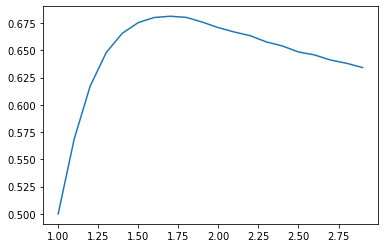

In [40]:
# same code as earlier but we want to test different threasholds that might work better than just the average one. 
# Copied from baseline code

bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSV("assignment1/train_Interactions.csv.gz"):
    bookCount[book] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

thresholds = [i/10 for i in range(10,30)]
accPerThreshold = {}


for thred in thresholds: 
    
    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalRead/thred: break
    
    acc1 = 0
    for d in negValidRatings:
        if d[1] not in return1:
            acc1 += d[-1]==0
        else:
            acc1 += d[-1]==1
    acc1 /= len(negValidRatings)
    accPerThreshold[thred]=acc1

import matplotlib.pyplot as plt
plt.plot(accPerThreshold.keys(), accPerThreshold.values())
plt.show()

In [41]:
acc2 = max(accPerThreshold.values())
threshold = max(accPerThreshold, key=accPerThreshold.get)
print([threshold, acc2])
answers['Q2'] = [threshold, acc2]

[1.7, 0.6812]


In [42]:
# copied from last HW 
def Jaccard(s1, s2):
    num = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    
    if denom == 0:
        return 0
    return num/denom  

In [43]:
# Get all the pairs 
booksPerUser = defaultdict(set)
usersPerbook = defaultdict(set)

for d in ratingsTrain:
    u = d[0]
    i = d[1]
    r = d[-1]
    if u in booksPerUser:
        booksPerUser[u].add(i)
    else:
        booksPerUser[u] = {i}
        
    if i in usersPerbook:
        usersPerbook[i].add(u)
    else:
        usersPerbook[i] = {u}

In [44]:
def predictRead(threshold):
    acc0 = 0
    for d in negValidRatings: # pairs in validation set 
        u = d[0]
        b = d[1]
        books = booksPerUser[d[0]] # consider all training items b′ that user u has read 
        similarities = []
        if books: #if user has read any book previously 
            for b1 in books:
                if(b==b1):
                    continue
                if b in usersPerbook:
                    sim = Jaccard(usersPerbook[b], usersPerbook[b1])
                    similarities.append(sim)
                else:
                    similarities.append(0) #no similarity 
            isRead = d[-1]==1
            isNotRead = d[-1]==0
            
            if (threshold < max(similarities)):
                acc0 += isRead
            else:
                acc0 += isNotRead
    acc0 /=len(negValidRatings)
    
    return acc0

thresholds = []
for i in range(1,15): 
    thresholds.append(1/(2**i))
# thresholds

In [45]:
accPerThreshold = {}
for thred in thresholds:
    accPerThreshold[thred] = predictRead(thred)
    print("For threshold: {}, accuracy = {}" .format(thred, accPerThreshold[thred]))

acc3 = max(accPerThreshold.values())
threshold = max(accPerThreshold, key=accPerThreshold.get)
print([threshold, acc3])

For threshold: 0.5, accuracy = 0.49855
For threshold: 0.25, accuracy = 0.49855
For threshold: 0.125, accuracy = 0.49855
For threshold: 0.0625, accuracy = 0.49945
For threshold: 0.03125, accuracy = 0.50185
For threshold: 0.015625, accuracy = 0.51625
For threshold: 0.0078125, accuracy = 0.60685
For threshold: 0.00390625, accuracy = 0.64105
For threshold: 0.001953125, accuracy = 0.6272
For threshold: 0.0009765625, accuracy = 0.6183
For threshold: 0.00048828125, accuracy = 0.6183
For threshold: 0.000244140625, accuracy = 0.6183
For threshold: 0.0001220703125, accuracy = 0.6183
For threshold: 6.103515625e-05, accuracy = 0.6183
[0.00390625, 0.64105]


In [46]:
# Copied from baseline code
bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSV("assignment1/train_Interactions.csv.gz"):
    bookCount[book] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    # threshold for mostpopular
    popular_threashold = answers['Q2'][0]
    if count > totalRead/popular_threashold: break
    # instead of threshold i had answers['Q2'][0]

In [47]:
answers['Q2']

[1.7, 0.6812]

In [48]:
def Cosine_btwn_users(u1, u2, booksPerUser, ratingDict):
    '''
     Compute similarity Between two users based on the ratings 
     they gave to the books they both have read
    '''
    # inter contains the books both users have read 
    inter = booksPerUser[u1].intersection(booksPerUser[u2])
    numer = 0
    denom1 = 0
    denom2 = 0
    
    for book in inter:
        numer += ratingDict[(u1,b)]*ratingDict[(u2,b)]
        
    for book in booksPerUser[u1]:
        denom1 += ratingDict[(u1,book)]**2
        
    for book in booksPerUser[u2]:
        denom2 += ratingDict[(u2,book)]**2
        
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    
    if denom == 0: return 0
    
    return numer / denom

In [49]:
# taken from the workbook of chapter 4
def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

In [50]:
def get_mutuals(d): 
    
    mutual_book = []
    for p in negValidRatings:
        d1 = p[0]
        if d == d1: continue 
        s1 = set(booksPerUser[d])
        s2 = set(booksPerUser[d1])
#         print("s1: ", s1)
#         print("s2: ", s2)
#         break
        sim = len(s1.intersection(s2))
        mutual_book.append((d1,sim))
    
    sim_users = []
    m = sorted(mutual_book,key=lambda x: x[1], reverse=True)
    t = m[0:5]
    for pair in t: 
        sim_users.append(pair[0])            
            
    return sim_users

In [51]:
def predictRead(threshold):
    acc0 = 0
    random.shuffle(negValidRatings)
    for d in negValidRatings: # pairs in validation set 
        u = d[0]
        b = d[1]
        # consider all training items b′ that user u has read 
        books = booksPerUser[d[0]] 
        similarities = []
        if books: #if user has read any book previously 
            for b1 in books: # for all books user has read
                if(b==b1):
                    continue
                if b in usersPerbook:
                    sim = Jaccard(usersPerbook[b], usersPerbook[b1])
                    similarities.append(sim)
#                     sim2 = Cosine_btwn_users(b, b1, usersPerbook, ratingDict)
#                     similarities.append(sim2)
#                     sim3 = CosineSet(usersPerbook[b], usersPerbook[b1])
                else:
                    similarities.append(0) #no similarity 
    
            isRead = d[-1]==1
            isNotRead = d[-1]==0
            

#             sim_users = get_mutuals(user)
#             count = 0
#             for userX in sim_users: 
#                 if b in booksPerUser[userX]: 
#                     count += 1 
            if (threshold < max(similarities)) and b in return1: 
                acc0 += isRead
#             elif count > 2: 
#                 acc0 += isRead
            else:
                acc0 += isNotRead
    acc0 /=len(negValidRatings)
    
    return acc0


# acc4 = predictRead(threshold)
thresholds = []
for i in range(1,13): 
    thresholds.append(1/(2**i))
# thresholds

In [52]:
accPerThreshold = {}
for thred in thresholds:
    accPerThreshold[thred] = predictRead(thred)
    print("For threshold: {}, accuracy = {}" .format(thred, accPerThreshold[thred]))

acc4 = max(accPerThreshold.values())
threshold = max(accPerThreshold, key=accPerThreshold.get)
print([threshold, acc4])

For threshold: 0.5, accuracy = 0.49855
For threshold: 0.25, accuracy = 0.49855
For threshold: 0.125, accuracy = 0.49855
For threshold: 0.0625, accuracy = 0.49855
For threshold: 0.03125, accuracy = 0.4991
For threshold: 0.015625, accuracy = 0.5169
For threshold: 0.0078125, accuracy = 0.61585
For threshold: 0.00390625, accuracy = 0.66765
For threshold: 0.001953125, accuracy = 0.6763
For threshold: 0.0009765625, accuracy = 0.67675
For threshold: 0.00048828125, accuracy = 0.67675
For threshold: 0.000244140625, accuracy = 0.67675
[0.0009765625, 0.67675]


In [53]:
threshold, acc4

(0.0009765625, 0.67675)

In [54]:
predictions = open("predictions_Read.csv", 'w')
for l in open("assignment1/pairs_Read.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,b = l.strip().split(',')
    maxSim = 0
    users = set(ratingsPerItem[b])
    for b2,_ in ratingsPerUser[u]:
        sim = Jaccard(users,set(ratingsPerItem[b2])) 
#         sim2 = Cosine_btwn_users(b, b2, usersPerbook, ratingDict)
        
        if sim > maxSim:
            maxSim = sim
#         if sim2 > maxSim:
#             maxSim = sim2
    pred = 0
    if maxSim > 0.014 or len(ratingsPerItem[b]) > 40: #threshold
        pred = 1
    _ = predictions.write(u + ',' + b + ',' + str(pred) + '\n')

predictions.close()


In [55]:
# Shivani's HW3 code 
# RATING PREDICTION: 1.476984769313793
# READ PREDICTION: 0.7648

#Shivani's HW3 with added cousin with jaccard sum to Read Prediction 
# 0.7493
# just cosin 
# 0.7618
# 

# Highest so far 
# 1.4548441561680348
# 0.8572